# Two-Stage Olympic Medal Prediction Model

## Overview
This notebook implements a two-stage prediction approach:
1. **Stage A (Classification)**: Predict whether a country wins any medals (binary)
2. **Stage B (Regression)**: Predict medal count for countries predicted to win medals

## What to Run
Simply run all cells in order. The notebook will:
- Load and explore data
- Preprocess features with pipelines
- Split data by time (train ≤2012, val=2016, test=2020+)
- Train classifier and regressor with hyperparameter tuning
- Evaluate both stages
- Save models for inference

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_recall_fscore_support,
    mean_absolute_error, mean_squared_error, precision_recall_curve
)

import xgboost as xgb
from scipy.stats import randint, uniform

# Create directories
Path('models').mkdir(exist_ok=True)
Path('figures').mkdir(exist_ok=True)
Path('results').mkdir(exist_ok=True)

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Imports complete")

✓ Imports complete


## 1. Load Data

In [2]:
# Load merged dataset
df = pd.read_csv('data/processed/olympics_merged.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst rows:")
print(df.head())

print(f"\nYear range: {df['year'].min()} - {df['year'].max()}")
print(f"Countries: {df['iso3'].nunique()}")
print(f"\nGames distribution:")
print(df['games_type'].value_counts())

Dataset shape: (7390, 15)

Columns: ['iso3', 'year', 'games_type', 'gold', 'silver', 'bronze', 'total_medals', 'has_medal', 'country', 'population', 'gdp_current_usd', 'gdp_per_capita', 'life_expectancy', 'adult_literacy_rate', 'unemployment_rate']

First rows:
  iso3  year games_type  gold  silver  bronze  total_medals  has_medal  \
0  AUS  2022     Winter   1.0     2.0     1.0           4.0          1   
1  AUT  2022     Winter   7.0     7.0     4.0          18.0          1   
2  BLR  2022     Winter   0.0     2.0     0.0           2.0          1   
3  BEL  2022     Winter   1.0     0.0     1.0           2.0          1   
4  CAN  2022     Winter   4.0     8.0    14.0          26.0          1   

     country  population  gdp_current_usd  gdp_per_capita  life_expectancy  \
0  Australia  26014399.0     1.690858e+12    64997.013654        83.200000   
1    Austria   9041851.0     4.717736e+11    52176.664914        81.295122   
2    Belarus   9228071.0     7.377518e+10     7994.648061  

## 2. Exploratory Data Analysis

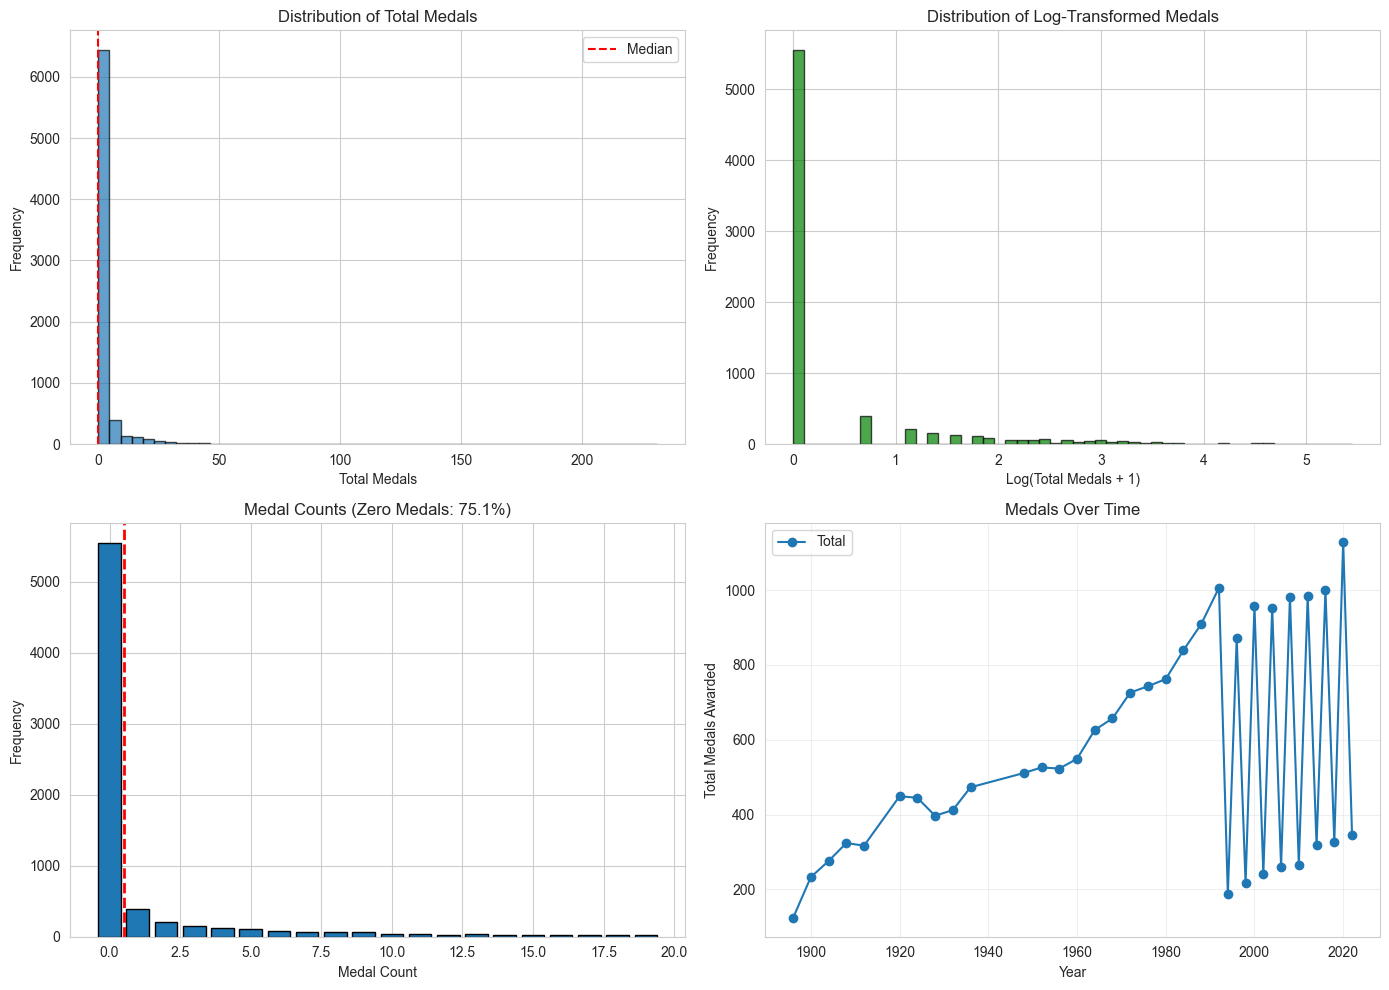


📊 Medal Statistics:
  Zero medals: 75.1%
  Mean medals: 2.82
  Median medals: 0
  Max medals: 231


In [3]:
# Medal distribution
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Total medals histogram
axes[0, 0].hist(df['total_medals'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Total Medals')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Total Medals')
axes[0, 0].axvline(df['total_medals'].median(), color='red', linestyle='--', label='Median')
axes[0, 0].legend()

# Log-scale medals
axes[0, 1].hist(np.log1p(df['total_medals']), bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Log(Total Medals + 1)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Log-Transformed Medals')

# Zero proportion
zero_prop = (df['total_medals'] == 0).mean()
medal_counts = df['total_medals'].value_counts().sort_index().head(20)
axes[1, 0].bar(medal_counts.index, medal_counts.values, edgecolor='black')
axes[1, 0].set_xlabel('Medal Count')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Medal Counts (Zero Medals: {zero_prop:.1%})')
axes[1, 0].axvline(0.5, color='red', linestyle='--', linewidth=2)

# Medals by year
medals_by_year = df.groupby('year')['total_medals'].agg(['sum', 'mean', 'count'])
axes[1, 1].plot(medals_by_year.index, medals_by_year['sum'], marker='o', label='Total')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Total Medals Awarded')
axes[1, 1].set_title('Medals Over Time')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('figures/eda_medal_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n📊 Medal Statistics:")
print(f"  Zero medals: {zero_prop:.1%}")
print(f"  Mean medals: {df['total_medals'].mean():.2f}")
print(f"  Median medals: {df['total_medals'].median():.0f}")
print(f"  Max medals: {df['total_medals'].max():.0f}")

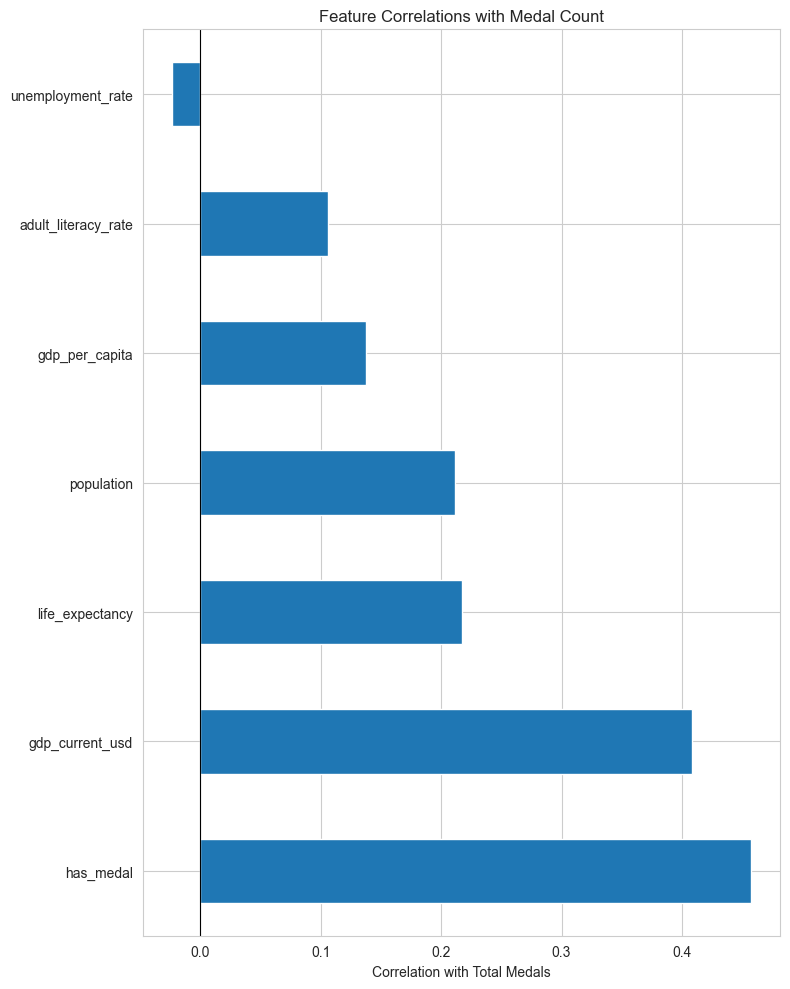


📊 Top correlations with medals:
has_medal              0.457335
gdp_current_usd        0.408650
life_expectancy        0.217525
population             0.211661
gdp_per_capita         0.137956
adult_literacy_rate    0.105901
unemployment_rate     -0.023824
Name: total_medals, dtype: float64


In [4]:
# Feature correlations with medals
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['year', 'gold', 'silver', 'bronze']]

if len(numeric_cols) > 2:
    corr_with_medals = df[numeric_cols].corr()['total_medals'].sort_values(ascending=False)
    
    fig, ax = plt.subplots(figsize=(8, 10))
    corr_with_medals.drop('total_medals').plot(kind='barh', ax=ax)
    ax.set_xlabel('Correlation with Total Medals')
    ax.set_title('Feature Correlations with Medal Count')
    ax.axvline(0, color='black', linestyle='-', linewidth=0.8)
    plt.tight_layout()
    plt.savefig('figures/eda_correlations.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n📊 Top correlations with medals:")
    print(corr_with_medals.drop('total_medals').head(10))

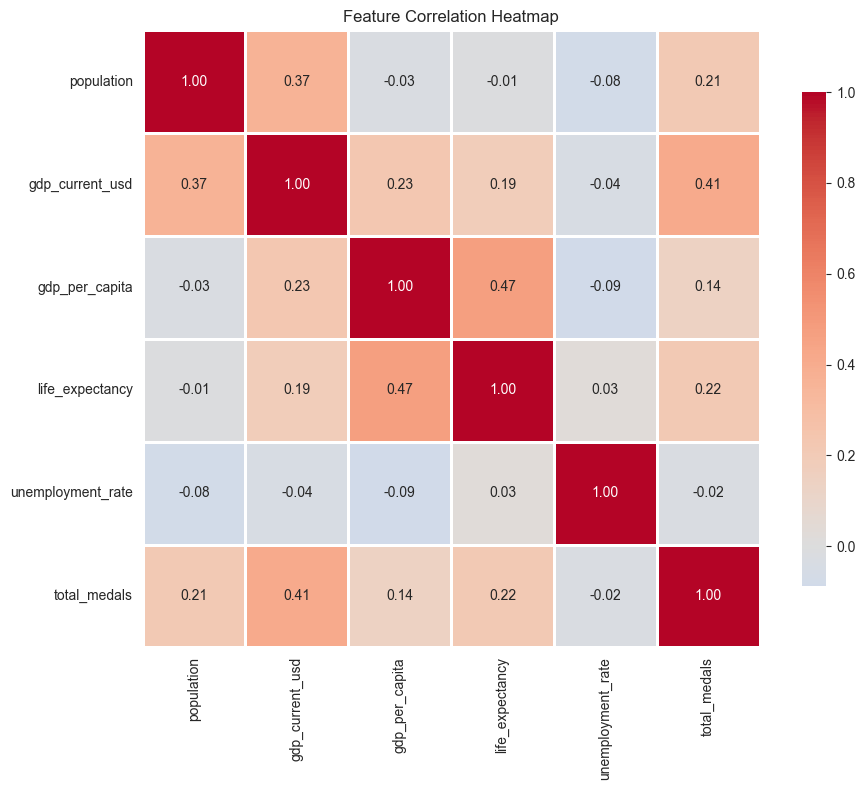

In [5]:
# Correlation heatmap of predictors
predictor_cols = ['population', 'gdp_current_usd', 'gdp_per_capita', 
                  'life_expectancy', 'unemployment_rate']
predictor_cols = [c for c in predictor_cols if c in df.columns]

if len(predictor_cols) > 1:
    corr_matrix = df[predictor_cols + ['total_medals']].corr()
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.savefig('figures/eda_heatmap.png', dpi=150, bbox_inches='tight')
    plt.show()

## 3. Data Preprocessing

In [6]:
# 1️⃣ Define features and targets
exclude_cols = ['iso3', 'country_name', 'year', 'gold', 'silver', 'bronze', 'total_medals', 'country']

feature_cols = [c for c in df.columns if c not in exclude_cols]

# Remove target columns explicitly (important to avoid leakage)
feature_cols = [f for f in feature_cols if f not in ['has_medal', 'total_medals']]

# 2️⃣ Separate numeric and categorical features using full df
numeric_features = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df[feature_cols].select_dtypes(include=['object']).columns.tolist()

print(f"\n📋 Feature Engineering:")
print(f"  Numeric features ({len(numeric_features)}): {numeric_features}")
print(f"  Categorical features ({len(categorical_features)}): {categorical_features}")

# 3️⃣ Then do the time-aware split
train_df = df[df['year'] <= 2012].copy()
val_df = df[df['year'] == 2016].copy()
test_df = df[df['year'] >= 2020].copy()



📋 Feature Engineering:
  Numeric features (6): ['population', 'gdp_current_usd', 'gdp_per_capita', 'life_expectancy', 'adult_literacy_rate', 'unemployment_rate']
  Categorical features (1): ['games_type']


In [7]:
# Create preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("✓ Preprocessing pipeline created")

✓ Preprocessing pipeline created


## 4. Time-Aware Data Split

In [8]:
# Time-aware split: train ≤ 2012, val = 2016, test = 2020+
train_df = df[df['year'] <= 2012].copy()
val_df = df[df['year'] == 2016].copy()
test_df = df[df['year'] >= 2020].copy()

# Fallback to percentage split if year-based split insufficient
if len(val_df) < 50 or len(test_df) < 50:
    print("⚠️  Using percentage-based split instead of year-based")
    train_df = df[df['year'] < df['year'].quantile(0.7)].copy()
    val_df = df[(df['year'] >= df['year'].quantile(0.7)) & 
                (df['year'] < df['year'].quantile(0.85))].copy()
    test_df = df[df['year'] >= df['year'].quantile(0.85)].copy()

print(f"\n📊 Data Split:")
print(f"  Train: {len(train_df)} samples, years {train_df['year'].min()}-{train_df['year'].max()}")
print(f"  Val:   {len(val_df)} samples, years {val_df['year'].min()}-{val_df['year'].max()}")
print(f"  Test:  {len(test_df)} samples, years {test_df['year'].min()}-{test_df['year'].max()}")

# Prepare features and targets
X_train = train_df[feature_cols]
X_val = val_df[feature_cols]
X_test = test_df[feature_cols]

# Classification targets
y_train_class = train_df['has_medal']
y_val_class = val_df['has_medal']
y_test_class = test_df['has_medal']

# Regression targets (only for rows with medals)
y_train_reg = train_df.loc[train_df['has_medal']==1, 'total_medals']
y_val_reg = val_df.loc[val_df['has_medal']==1, 'total_medals']
y_test_reg = test_df.loc[test_df['has_medal']==1, 'total_medals']

print(f"\n🎯 Class Balance:")
print(f"  Train: {y_train_class.value_counts().to_dict()}")
print(f"  Val:   {y_val_class.value_counts().to_dict()}")
print(f"  Test:  {y_test_class.value_counts().to_dict()}")


📊 Data Split:
  Train: 6683 samples, years 1896-2012
  Val:   145 samples, years 2016-2016
  Test:  282 samples, years 2020-2022

🎯 Class Balance:
  Train: {0: 5119, 1: 1564}
  Val:   {1: 90, 0: 55}
  Test:  {0: 155, 1: 127}


In [9]:
# Fit preprocessor and transform data
X_train_processed = preprocessor.fit_transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

# For regression, get processed features for medal winners only
X_train_reg_processed = X_train_processed[train_df['has_medal']==1]
X_val_reg_processed = X_val_processed[val_df['has_medal']==1]
X_test_reg_processed = X_test_processed[test_df['has_medal']==1]

print(f"\n✓ Preprocessing complete")
print(f"  Classification features shape: {X_train_processed.shape}")
print(f"  Regression features shape: {X_train_reg_processed.shape}")

# Save preprocessor
joblib.dump(preprocessor, 'models/preprocessor.joblib')
print("✓ Preprocessor saved")


✓ Preprocessing complete
  Classification features shape: (6683, 8)
  Regression features shape: (1564, 8)
✓ Preprocessor saved


## 5. Stage A: Classification Model (Has Medal?)

In [10]:
# Calculate scale_pos_weight for class imbalance
scale_pos_weight = (y_train_class == 0).sum() / (y_train_class == 1).sum()

print(f"\n🎯 Training Classification Model (Stage A)")
print(f"  Class imbalance ratio: {scale_pos_weight:.2f}")

# Define parameter distribution for RandomizedSearch
param_dist_clf = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'n_estimators': randint(100, 500),
    'min_child_weight': randint(1, 10),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
}

# Base classifier
base_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric='auc',
    use_label_encoder=False
)

# Randomized search
random_search_clf = RandomizedSearchCV(
    base_clf,
    param_distributions=param_dist_clf,
    n_iter=20,
    scoring='roc_auc',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n⏳ Running hyperparameter search (20 iterations, 3-fold CV)...")
random_search_clf.fit(X_train_processed, y_train_class)

print(f"\n✓ Best parameters: {random_search_clf.best_params_}")
print(f"✓ Best CV ROC AUC: {random_search_clf.best_score_:.4f}")

classifier = random_search_clf.best_estimator_


🎯 Training Classification Model (Stage A)
  Class imbalance ratio: 3.27

⏳ Running hyperparameter search (20 iterations, 3-fold CV)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits

✓ Best parameters: {'colsample_bytree': np.float64(0.6399899663272012), 'gamma': np.float64(0.22962444598293358), 'learning_rate': np.float64(0.07674172222780437), 'max_depth': 5, 'min_child_weight': 6, 'n_estimators': 408, 'subsample': np.float64(0.9879639408647978)}
✓ Best CV ROC AUC: 0.8990


In [11]:
# Evaluate classifier on validation set
y_val_pred_proba = classifier.predict_proba(X_val_processed)[:, 1]

# Find optimal threshold by maximizing F1 score
precisions, recalls, thresholds = precision_recall_curve(y_val_class, y_val_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5

print(f"\n🎯 Optimal threshold (max F1 on validation): {optimal_threshold:.3f}")

# Make predictions with optimal threshold
y_val_pred = (y_val_pred_proba >= optimal_threshold).astype(int)

# Calculate metrics
val_roc_auc = roc_auc_score(y_val_class, y_val_pred_proba)
val_pr_auc = average_precision_score(y_val_class, y_val_pred_proba)
precision, recall, f1, _ = precision_recall_fscore_support(y_val_class, y_val_pred, average='binary')

print(f"\n📊 Validation Metrics (Classification):")
print(f"  ROC AUC:    {val_roc_auc:.4f}")
print(f"  PR AUC:     {val_pr_auc:.4f}")
print(f"  Precision:  {precision:.4f}")
print(f"  Recall:     {recall:.4f}")
print(f"  F1 Score:   {f1:.4f}")

# Save classifier and threshold
joblib.dump(classifier, 'models/classifier.joblib')
joblib.dump(optimal_threshold, 'models/optimal_threshold.joblib')
print("\n✓ Classifier saved")


🎯 Optimal threshold (max F1 on validation): 0.628

📊 Validation Metrics (Classification):
  ROC AUC:    0.8492
  PR AUC:     0.9053
  Precision:  0.7921
  Recall:     0.8889
  F1 Score:   0.8377

✓ Classifier saved


## 6. Stage B: Regression Model (Medal Count)

In [12]:
print(f"\n🎯 Training Regression Model (Stage B)")
print(f"  Training on {len(y_train_reg)} medal-winning countries")

# Parameter distribution
param_dist_reg = {
    'max_depth': randint(3, 8),
    'learning_rate': uniform(0.01, 0.15),
    'n_estimators': randint(100, 400),
    'min_child_weight': randint(1, 5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.3),
}

# Base regressor
base_reg = xgb.XGBRegressor(
    objective='count:poisson',
    random_state=42,
    eval_metric='mae'
)

# Randomized search
random_search_reg = RandomizedSearchCV(
    base_reg,
    param_distributions=param_dist_reg,
    n_iter=15,
    scoring='neg_mean_absolute_error',
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

print("\n⏳ Running hyperparameter search (15 iterations, 3-fold CV)...")
random_search_reg.fit(X_train_reg_processed, y_train_reg)

print(f"\n✓ Best parameters: {random_search_reg.best_params_}")
print(f"✓ Best CV MAE: {-random_search_reg.best_score_:.4f}")

regressor = random_search_reg.best_estimator_


🎯 Training Regression Model (Stage B)
  Training on 1564 medal-winning countries

⏳ Running hyperparameter search (15 iterations, 3-fold CV)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits

✓ Best parameters: {'colsample_bytree': np.float64(0.6739417822102108), 'gamma': np.float64(0.29087538832936755), 'learning_rate': np.float64(0.1262699235041672), 'max_depth': 4, 'min_child_weight': 2, 'n_estimators': 369, 'subsample': np.float64(0.8909087983425683)}
✓ Best CV MAE: 6.8928


In [13]:
# Evaluate regressor on validation set
y_val_reg_pred = regressor.predict(X_val_reg_processed)
y_val_reg_pred = np.maximum(y_val_reg_pred, 0)  # Ensure non-negative

val_mae = mean_absolute_error(y_val_reg, y_val_reg_pred)
val_rmse = np.sqrt(mean_squared_error(y_val_reg, y_val_reg_pred))

print(f"\n📊 Validation Metrics (Regression):")
print(f"  MAE:  {val_mae:.4f}")
print(f"  RMSE: {val_rmse:.4f}")

# Save regressor
joblib.dump(regressor, 'models/regressor.joblib')
print("\n✓ Regressor saved")


📊 Validation Metrics (Regression):
  MAE:  5.1735
  RMSE: 7.9253

✓ Regressor saved


In [14]:
# Baseline comparisons
print("\n📊 Baseline Comparisons")
print("="*60)

# Baseline 1: Always predict mean
mean_medals = train_df[train_df['has_medal']==1]['total_medals'].mean()
baseline_mean_pred = np.full(len(y_val_reg), mean_medals)
baseline_mean_mae = mean_absolute_error(y_val_reg, baseline_mean_pred)
print(f"\nBaseline 1: Predict mean ({mean_medals:.2f} medals)")
print(f"  MAE: {baseline_mean_mae:.4f}")

# Baseline 2: Median
median_medals = train_df[train_df['has_medal']==1]['total_medals'].median()
baseline_median_pred = np.full(len(y_val_reg), median_medals)
baseline_median_mae = mean_absolute_error(y_val_reg, baseline_median_pred)
print(f"\nBaseline 2: Predict median ({median_medals:.0f} medals)")
print(f"  MAE: {baseline_median_mae:.4f}")

# Model improvement over mean baseline
improvement = (baseline_mean_mae - val_mae) / baseline_mean_mae * 100
print(f"\n✨ Model Improvement over Mean Baseline: {improvement:.1f}%")

# Classification baseline: always predict majority class
majority_class = y_train_class.mode()[0]
baseline_clf_acc = (y_val_class == majority_class).mean()
model_clf_acc = (y_val_pred == y_val_class).mean()

print(f"\nClassification Accuracy:")
print(f"  Baseline (majority class): {baseline_clf_acc:.4f}")
print(f"  Our model: {model_clf_acc:.4f}")


📊 Baseline Comparisons

Baseline 1: Predict mean (11.35 medals)
  MAE: 10.7324

Baseline 2: Predict median (5 medals)
  MAE: 9.1778

✨ Model Improvement over Mean Baseline: 51.8%

Classification Accuracy:
  Baseline (majority class): 0.3793
  Our model: 0.7862
